# NORTH

Dette script lader dig læse og behandle data fra tokamakken NORTH. For at køre scriptet skal du uploade dine datafiler i mappen  `Data`. Du skal derefter angive nummeret på det eksperiment du ønsker at undersøge:


In [4]:
shot = 9774

## Importer Biblioteker

In [ ]:
!git clone https://github.com/thrysoe/north.git
%cd north

In [ ]:
import nptdms
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from Diagnostics import Probe

data_path   = './Data/'
figure_path = './Figures/'

## Indlæs Data

In [5]:
# Read probedata

probe = {}
for i in range(Probe.TOTAL_PROBES):
    probe[i] = Probe(path = data_path, shot = shot, number = i + 1, caching = True)

🔄 Loading position data for Shot #9774
🔄 Loading mapping data for Shot #9774
🔄 Bulk loading probe data for Shot #9774


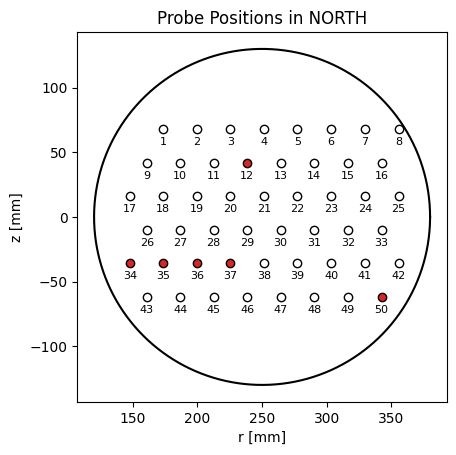

In [6]:
# Plot probe positions

fig, ax = plt.subplots()

theta = np.linspace(0, 2 * np.pi, 500)
circle_x = 250 + 130 * np.cos(theta)
circle_z = 130 * np.sin(theta)
ax.plot(circle_x, circle_z, 'k')
ax.set_aspect('equal', adjustable='box')

for i in range(Probe.TOTAL_PROBES):
    ax.scatter(probe[i].position['r'], probe[i].position['z'], marker='o', edgecolors='k', facecolors='w' if probe[i].active else 'C3')
    ax.text(probe[i].position['r'], probe[i].position['z'] - 10, str(probe[i].number), color='black', fontsize=8, ha='center', va='center')

ax.set_xlabel('r [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Probe Positions in NORTH')

fig.savefig(f'{figure_path}/shot_{shot}__probe_positions.png', dpi = 300)


In [7]:
# Load control data

tdms_file = nptdms.TdmsFile.read(f"{data_path}/CRIO{shot}.tdms")

for group in tdms_file.groups():
    print(f"Group: {group.name}")
    for channel in group.channels():
        print(f"  Channel: {channel.name}")

Group: Data
  Channel: Temperature
  Channel: Light
  Channel: Microwave Power
  Channel: Pressure
  Channel: I_TF
  Channel: Reflected Power
  Channel: Time
  Channel: HFS Reflected Power
  Channel: HFS Power
  Channel: Req Power
  Channel: shot
  Channel: Manarm
  Channel: Gas
  Channel: IPF1
  Channel: VPF1
  Channel: HFSset
  Channel: LFSset
  Channel: Geiger
  Channel: HighLevel
  Channel: TotelLevel
  Channel: Serie
  Channel: IBFdump
  Channel: IBFplasma


## Analyser *Data*

Vælg det tidsinterval (målt i ms), som du ønsker at analysere data for. Hvis du ønsker at se hele dataserien, sæt:

`t_start, t_end = 0, -1`

In [8]:
t_start, t_end = 0, -1 # ms
# t_start, t_end = 200, 250 # ms
# t_start, t_end = 226, 232 # ms

t_end = tdms_file['Data']['Time'][-1] if t_end == -1 else t_end
mask = (tdms_file['Data']['Time'][:] >= t_start) & (tdms_file['Data']['Time'][:] <= t_end)

### Machine Data

Disse data beskriver de ydre faktorer, som plasmaet påvirkes af, f.eks. opvarmningseffekt og strøm i magnetfeltspolerne.

In [ ]:
# Strøm i toroidale magnetfeltspoler

fig,ax = plt.subplots()

ax.plot(tdms_file['Data']['Time'][mask], tdms_file['Data']['I_TF'][mask])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Current [A]")
ax.set_title(f"Toroidal Field Coil Current for Shot {shot}")

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__toroidal_field_coil_current.png', dpi = 300)

In [ ]:
# Gas tryk

fig,ax = plt.subplots()
ax.plot(tdms_file['Data']['Time'][mask], tdms_file['Data']['Pressure'][mask]*100)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Gas Pressure [Pa]")
ax.set_title(f"Gas Pressure for Shot {shot}")

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__gas_pressure.png', dpi = 300)

In [ ]:
# Mikrobølgeopvarmning fra ydersiden (LFS)

fig,ax = plt.subplots()

ax.plot(tdms_file['Data']['Time'][mask], tdms_file['Data']['LFSset'][mask]*450/3000)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("LFS Power [W]")
ax.set_title(f"LFS Microwave Heating for Shot {shot}")

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__LFS_microwave_heating.png', dpi = 300)

In [ ]:
# Mikrobølgeopvarmning fra indersiden (HFS)

fig,ax = plt.subplots()

ax.plot(tdms_file['Data']['Time'][mask], tdms_file['Data']['HFSset'][mask]*450/3000)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("HFS Power [W]")
ax.set_title(f"HFS Microwave Heating for Shot {shot}")

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__HFS_microwave_heating.png', dpi = 300)

### Langmuir Probe Data

Vælg den probe du ønsker at analysere data for, f.eks. for probe 42 sættes `p = 30`

In [ ]:
p = 30

In [ ]:
# Bias-spænding og probe-strøm som funktion af tid

idx_start, idx_end = probe[p].get_time_indices(t_start*1e-3, t_end*1e-3)

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(probe[p-1].time[idx_start:idx_end]*1e3, probe[p-1].bias_voltage[idx_start:idx_end])
ax[1].plot(probe[p-1].time[idx_start:idx_end]*1e3, probe[p-1].current[idx_start:idx_end]*1e3)

ax[1].set_xlim(t_start, t_end)

ax[0].set_ylabel("Bias Voltage [V]")
ax[1].set_ylabel("Probe Current [mA]")
ax[1].set_xlabel("Time [ms]")

fig.suptitle(f"Shot {probe[p-1].shot} : Probe {probe[p-1].number} Signal")
fig.tight_layout()

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__probe_signal.png', dpi = 300)

In [ ]:
# IV-karakteristik for proben

def I(V, I_sat, V_f, Te):
    return I_sat*(1 - np.exp((V - V_f)/(Te)))

idx_start, idx_end = probe[p].get_time_indices(t_start*1e-3, t_end*1e-3)

popt, pcov = curve_fit(I, probe[p-1].bias_voltage[idx_start:idx_end], probe[p-1].current[idx_start:idx_end]*1e3, p0=[0, 0, 10])  # p0 are initial guesses
I_sat, V_f, Te = popt

fig, ax = plt.subplots()
ax.plot(probe[p-1].bias_voltage[idx_start:idx_end], probe[p-1].current[idx_start:idx_end]*1e3, '.', label = 'probe data')
ax.plot(probe[p-1].bias_voltage[idx_start:idx_end], I(probe[p-1].bias_voltage[idx_start:idx_end], *popt), '-', label = 'curve fit')
ax.set_xlabel("Bias Voltage [V]")
ax.set_ylabel("Probe Current [mA]")
ax.legend()
ax.set_title(f"Shot {probe[p-1].shot} : Probe {probe[p-1].number} I-V Characteristic")

print(f"I_sat = {I_sat:.2f} mA")
print(f"V_f = {V_f:.2f} V")
print(f"kB*Te = {Te:.2f} eV")

fig.savefig(f'{figure_path}/shot_{shot}__time_{int(t_start)}_{int(t_end)}_ms__IV_characteristic.png', dpi = 300)